In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt


Xử lí dữ liệu , Đọc ảnh và phân loại

In [11]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            img = image.load_img(img_path, target_size=(224, 224))  # Chỉnh kích thước ảnh phù hợp với model
            img_array = image.img_to_array(img)
            img_array = preprocess_input(img_array)  # Tiền xử lý dữ liệu đầu vào
            images.append(img_array)
        except (IOError, OSError):  # Nếu không phải ảnh hợp lệ, bỏ qua file đó
            print(f"Skipped: {filename}")
    return np.array(images)

train_images = load_images_from_folder('/content/drive/MyDrive/Deep/OD/train')
test_images = load_images_from_folder('/content/drive/MyDrive/Deep/OD/test')




**Xây dựng mô hình (Model)**

In [6]:
# Sử dụng MobileNetV2 đã được huấn luyện sẵn, không bao gồm phần đầu ra (include_top=False)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Thêm các lớp tùy chỉnh vào mô hình
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)  # Lớp fully connected
x = Dense(1, activation='sigmoid')(x)  # Sử dụng 'sigmoid' nếu chỉ có 2 lớp (có và không có trái cây)

# Tạo mô hình hoàn chỉnh
model = Model(inputs=base_model.input, outputs=x)

# Freezing các lớp của MobileNetV2 để không cập nhật trong quá trình huấn luyện (chỉ huấn luyện lớp mới)
for layer in base_model.layers:
    layer.trainable = False

# Biên dịch mô hình với Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Tóm tắt cấu trúc mô hình
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 18,314,817 (69.87 MB)

 Trainable params: 16,056,833 (61.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

**Huấn luyện mô hình (Training).**

In [15]:
# Tạo nhãn cho 240 ảnh trong train (giả sử 120 ảnh trái cây và 120 ảnh không phải trái cây)
train_labels = np.array([1]*120 + [0]*120)  # Cập nhật theo nhãn thực tế của bạn

# Tạo nhãn cho 60 ảnh trong test (giả sử 30 ảnh trái cây và 30 ảnh không phải trái cây)
test_labels = np.array([1]*30 + [0]*30)  # Cập nhật theo nhãn thực tế của bạn


In [16]:
print(len(train_labels))  # Số lượng nhãn trong train_labels
print(len(test_labels))   # Số lượng nhãn trong test_labels


240
60


In [25]:
# Huấn luyện mô hình
model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(test_images, test_labels))



Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 1.0000 - loss: 3.8691e-05 - val_accuracy: 0.8167 - val_loss: 1.1187
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 1.0000 - loss: 4.2769e-05 - val_accuracy: 0.8167 - val_loss: 1.1213
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 1.0000 - loss: 4.5415e-05 - val_accuracy: 0.8167 - val_loss: 1.1237
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 1.0000 - loss: 3.7473e-05 - val_accuracy: 0.8167 - val_loss: 1.1256
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 1.0000 - loss: 3.5120e-05 - val_accuracy: 0.8167 - val_loss: 1.1275
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 1.0000 - loss: 3.9635e-05 - val_accuracy: 0.8167 - val_loss: 1.1299
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 1.0000 - loss: 4.1399e-05 - val_accuracy: 0.8167 - val_loss: 1.1323
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 1.0000 - loss: 3.2332e-05 - val_accuracy: 0.

In [26]:
# Đánh giá mô hình trên tập kiểm tra
loss, accuracy = model.evaluate(test_images, test_labels)

# In kết quả
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8361 - loss: 1.0823
Test Loss: 1.1374545097351074
Test Accuracy: 0.8166666626930237


In [27]:
# Dự đoán trên các ảnh trong tập kiểm tra
predictions = model.predict(test_images)

# In kết quả dự đoán
for i in range(5):  # In ra kết quả dự đoán cho 5 ảnh đầu tiên
    print(f"Predicted: {predictions[i]} - Actual: {test_labels[i]}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
Predicted: [0.997843] - Actual: 1
Predicted: [0.9961834] - Actual: 1
Predicted: [0.9999405] - Actual: 1
Predicted: [0.99816173] - Actual: 1
Predicted: [0.9999869] - Actual: 1


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


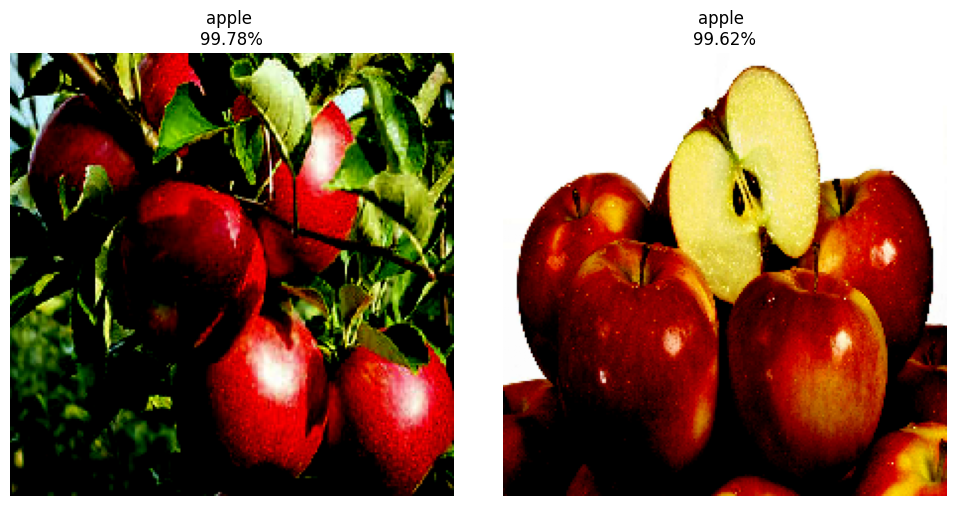

In [33]:
import matplotlib.pyplot as plt

# Dự đoán trên tất cả các ảnh trong test_images
predictions = model.predict(test_images)

# Số ảnh bạn muốn hiển thị (2 ảnh)
num_images = 2

# Tạo một hình với 1x2 grid để hiển thị 2 ảnh
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Lặp qua các ảnh và hiển thị chúng
for i in range(num_images):
    # Lấy ảnh và nhãn thực tế
    img = test_images[i]
    actual_label = test_labels[i]

    # Dự đoán cho ảnh
    predicted_prob = predictions[i][0]  # Xác suất của mô hình
    predicted_label = "apple" if predicted_prob > 0.5 else "not apple"

    # Vẽ ảnh
    ax = axes[i]  # Chọn vị trí trong grid (1x2)
    ax.imshow(img)
    ax.set_title(f"{predicted_label} \n{predicted_prob*100:.2f}%")
    ax.axis('off')  # Ẩn trục

plt.tight_layout()  # Điều chỉnh layout cho vừa vặn
plt.show()
